In [1]:
import scanpy as sc
import surgeon

Using TensorFlow backend.


In [2]:
sc.settings.set_figure_params(dpi=200)

In [3]:
condition_key = "batch"
cell_type_key = 'celltype'
target_conditions = ["Batch8", "Batch9"]

# Loading four Toy datasets and data preparation

In [4]:
adata = sc.read("./data/toy/toy_normalized.h5ad")
adata

AnnData object with n_obs × n_vars = 36000 × 5000 
    obs: 'batch', 'celltype', 'n_counts'

## Number of cells in each batch

In [5]:
adata.obs[condition_key].value_counts()

Batch9    4000
Batch8    4000
Batch7    4000
Batch6    4000
Batch5    4000
Batch4    4000
Batch3    4000
Batch2    4000
Batch1    4000
Name: batch, dtype: int64

## visualization  of the original data

In [6]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/mohsen/.local/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 45 separate connected components using meta-embedding (experimental)
  n_components


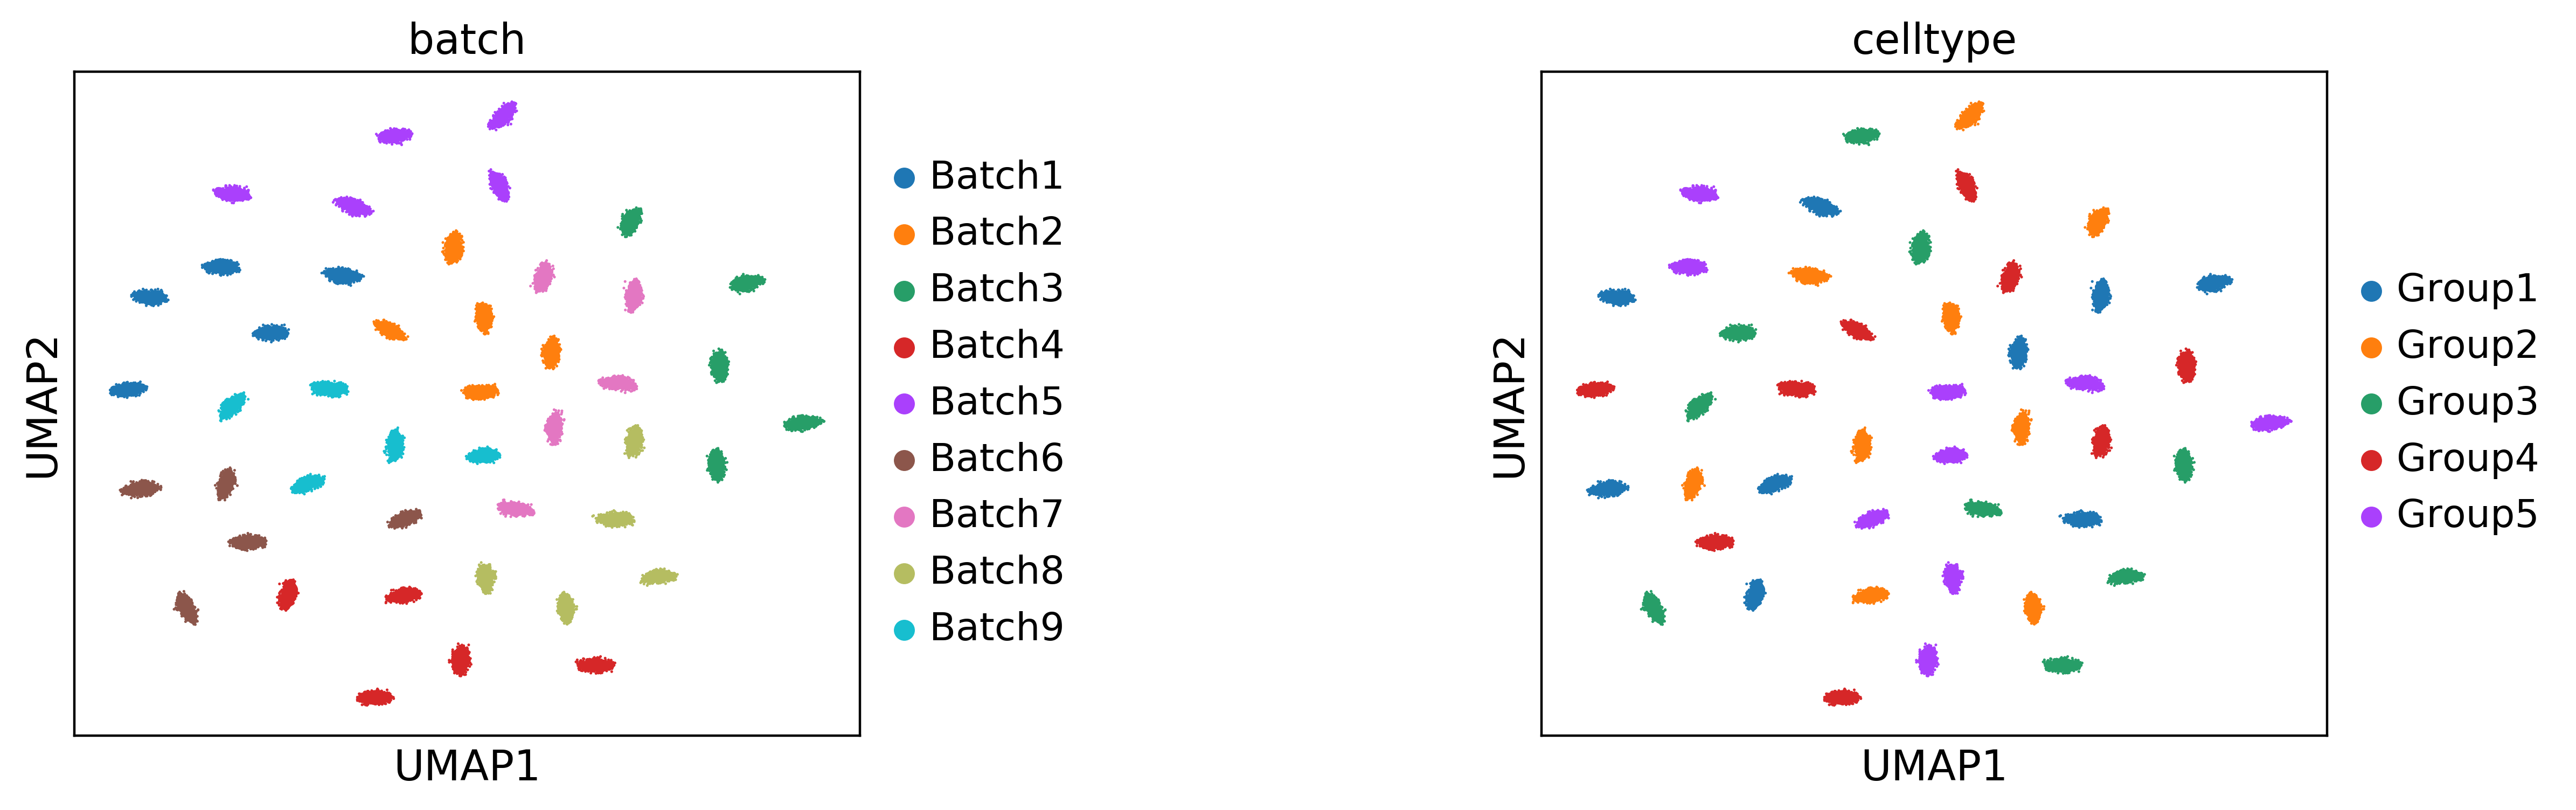

In [7]:
sc.pl.umap(adata, color=[condition_key, cell_type_key], wspace=0.7)

## Now we leave out one study (SS2) for training the newtork

In [7]:
adata_for_training = adata[~adata.obs[condition_key].isin(target_conditions)]
adata_for_training

View of AnnData object with n_obs × n_vars = 28000 × 5000 
    obs: 'batch', 'celltype', 'n_counts'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'

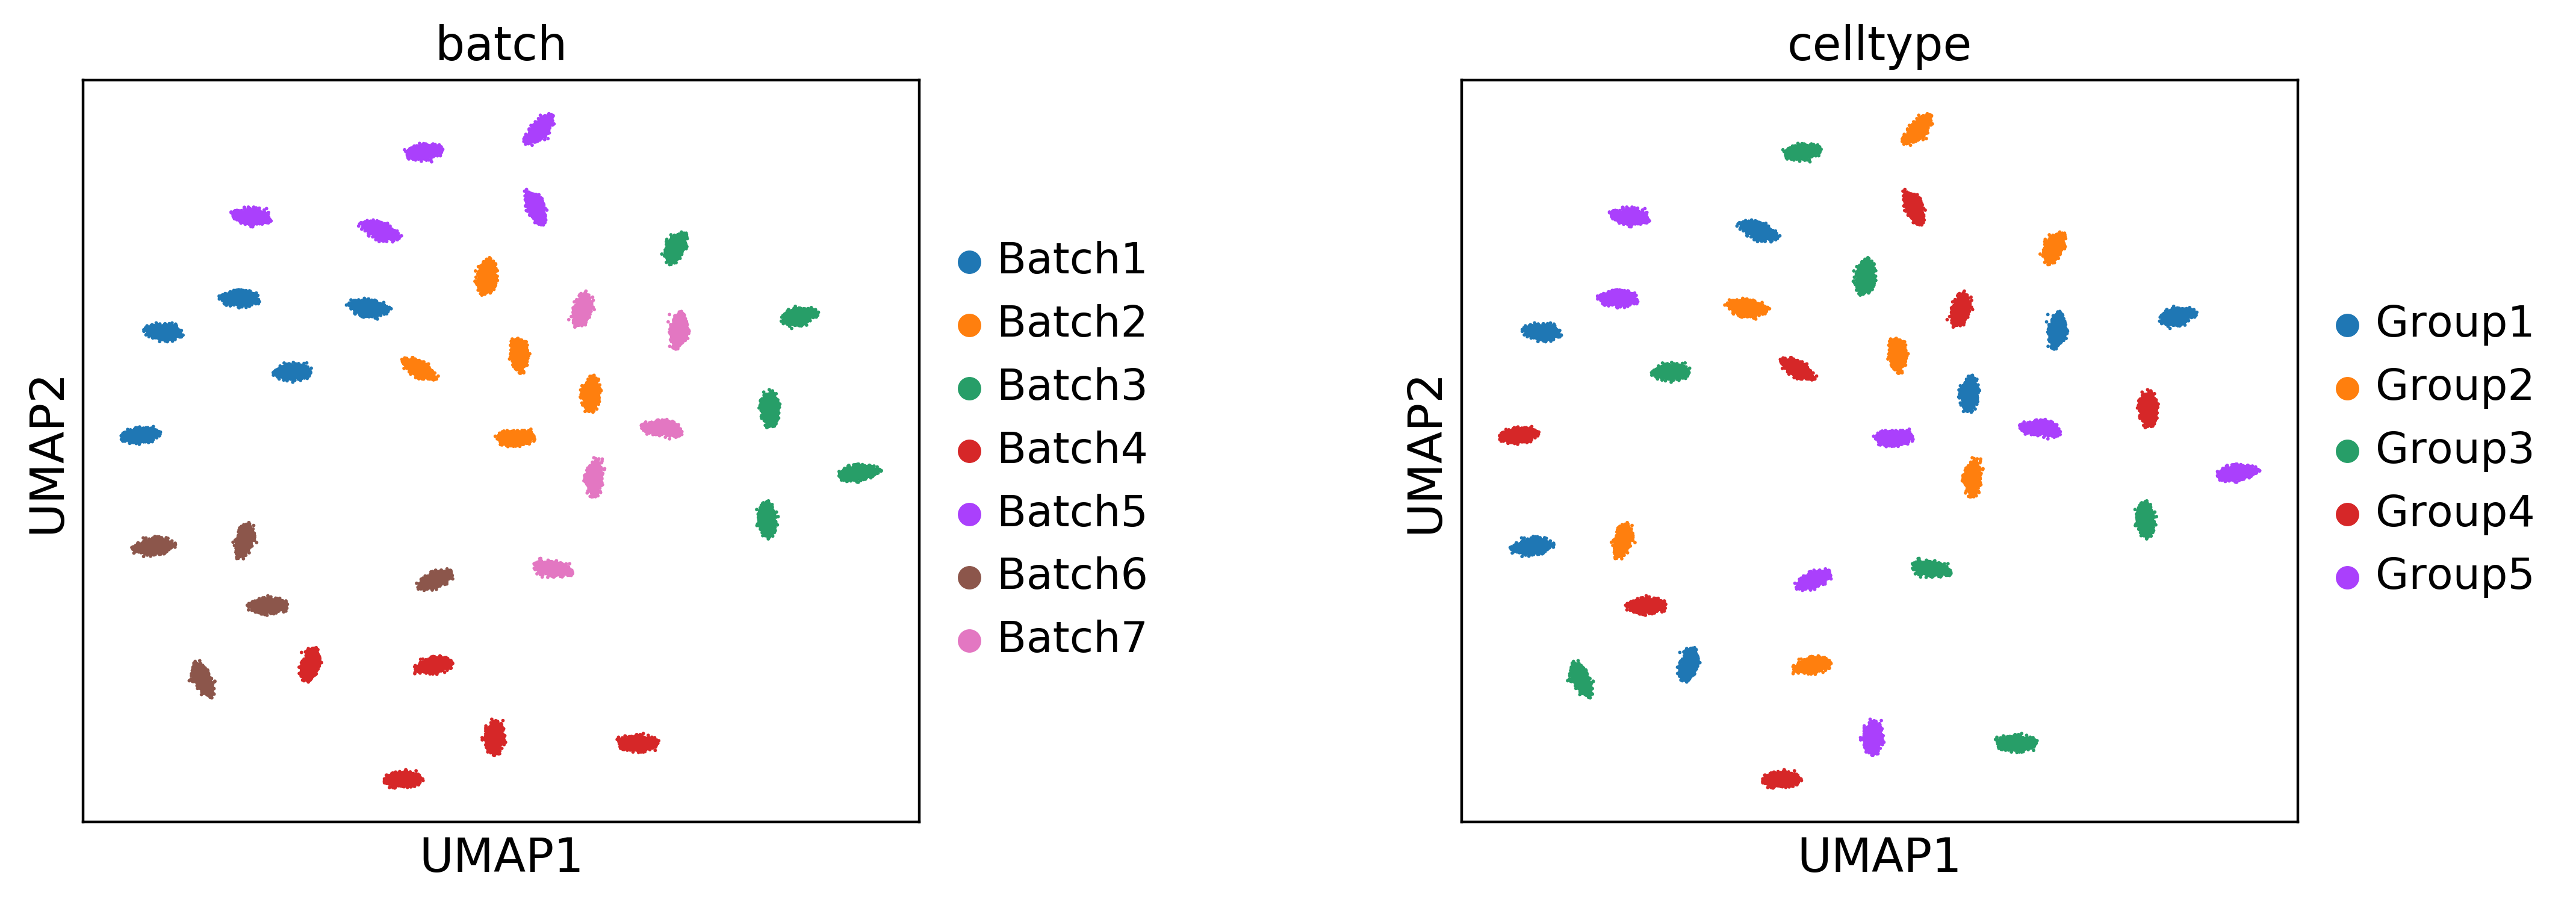

In [9]:
sc.pl.umap(adata_for_training, color=[condition_key, cell_type_key], wspace=0.5)

In [8]:
adata_out_of_sample = adata[adata.obs[condition_key].isin(target_conditions)]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 8000 × 5000 
    obs: 'batch', 'celltype', 'n_counts'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'

## Train/Test Split

In [9]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_for_training, 0.85)

In [10]:
train_adata.shape, valid_adata.shape

((23800, 5000), (4200, 5000))

In [11]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())

# Create & Train model with training data

In [12]:
network = surgeon.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=20,
                             n_conditions=n_conditions,
                             lr=0.001,
                             alpha=0.001,
                             eta=1.0,
                             clip_value=1e6,
                             loss_fn='mse',
                             model_path="./models/CVAE/Toy_normalized/",
                             dropout_rate=0.2,
                             output_activation='relu')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 5000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 7)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 5007)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
_____________________

## We assign each study to a numerical label 

In [13]:
conditions = adata_for_training.obs[condition_key].unique().tolist()
condition_encoder = surgeon.utils.create_dictionary(conditions, target_conditions)
condition_encoder

{'Batch1': 0,
 'Batch2': 1,
 'Batch3': 2,
 'Batch4': 3,
 'Batch5': 4,
 'Batch6': 5,
 'Batch7': 6}

## Training the network

In [14]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              le=condition_encoder, 
              n_epochs=200,
              batch_size=128, 
              early_stop_limit=20,
              lr_reducer=15, 
              n_per_epoch=0,
              save=True, 
              verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 23800 samples, validate on 4200 samples
Epoch 1/200
 - 3s - loss: 1259.4382 - kl_recon_loss: 1259.4382 - val_loss: 849.8896 - val_kl_recon_loss: 849.8896
Epoch 2/200
 - 2s - loss: 822.4192 - kl_recon_loss: 822.4192 - val_loss: 802.5024 - val_kl_recon_loss: 802.5024
Epoch 3/200
 - 2s - loss: 801.4828 - kl_recon_loss: 801.4828 - val_loss: 773.8857 - val_kl_recon_loss: 773.8857
Epoch 4/200
 - 2s - loss: 789.8432 - kl_recon_loss: 789.8432 - val_loss: 756.1127 - val_kl_recon_loss: 756.1127
Epoch 5/200
 - 2s - loss: 782.8029 - kl_recon_loss: 782.8029 - val_loss: 755.2622 - val_kl_recon_loss: 755.2622
Epoch 6/200
 - 2s - loss: 776.4796 - kl_recon_loss: 776.4796 - val_loss: 749.6467 - val_kl_recon_loss: 749.6467
Epoch 7/200
 - 2s - loss: 772.9839 - kl_recon_loss: 772.9839 - val_loss: 751.5810 - val_kl_recon_loss: 751.5810
Epoch 8/200
 - 2s - loss: 770.3073 - kl_recon_loss: 770.3073 - val_loss: 754.2297 - val_kl_recon_loss: 754.2297
Epoch

In [15]:
network.condition_encoder

{'Batch1': 0,
 'Batch2': 1,
 'Batch3': 2,
 'Batch4': 3,
 'Batch5': 4,
 'Batch6': 5,
 'Batch7': 6}

In [18]:
encoder_labels, _ = surgeon.utils.label_encoder(
    train_adata, label_encoder=network.condition_encoder, condition_key=condition_key)

In [19]:
latent_adata = network.to_latent(train_adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 23800 × 20 
    obs: 'batch', 'celltype', 'n_counts'

In [20]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

/home/mohsen/.local/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 29 separate connected components using meta-embedding (experimental)
  n_components


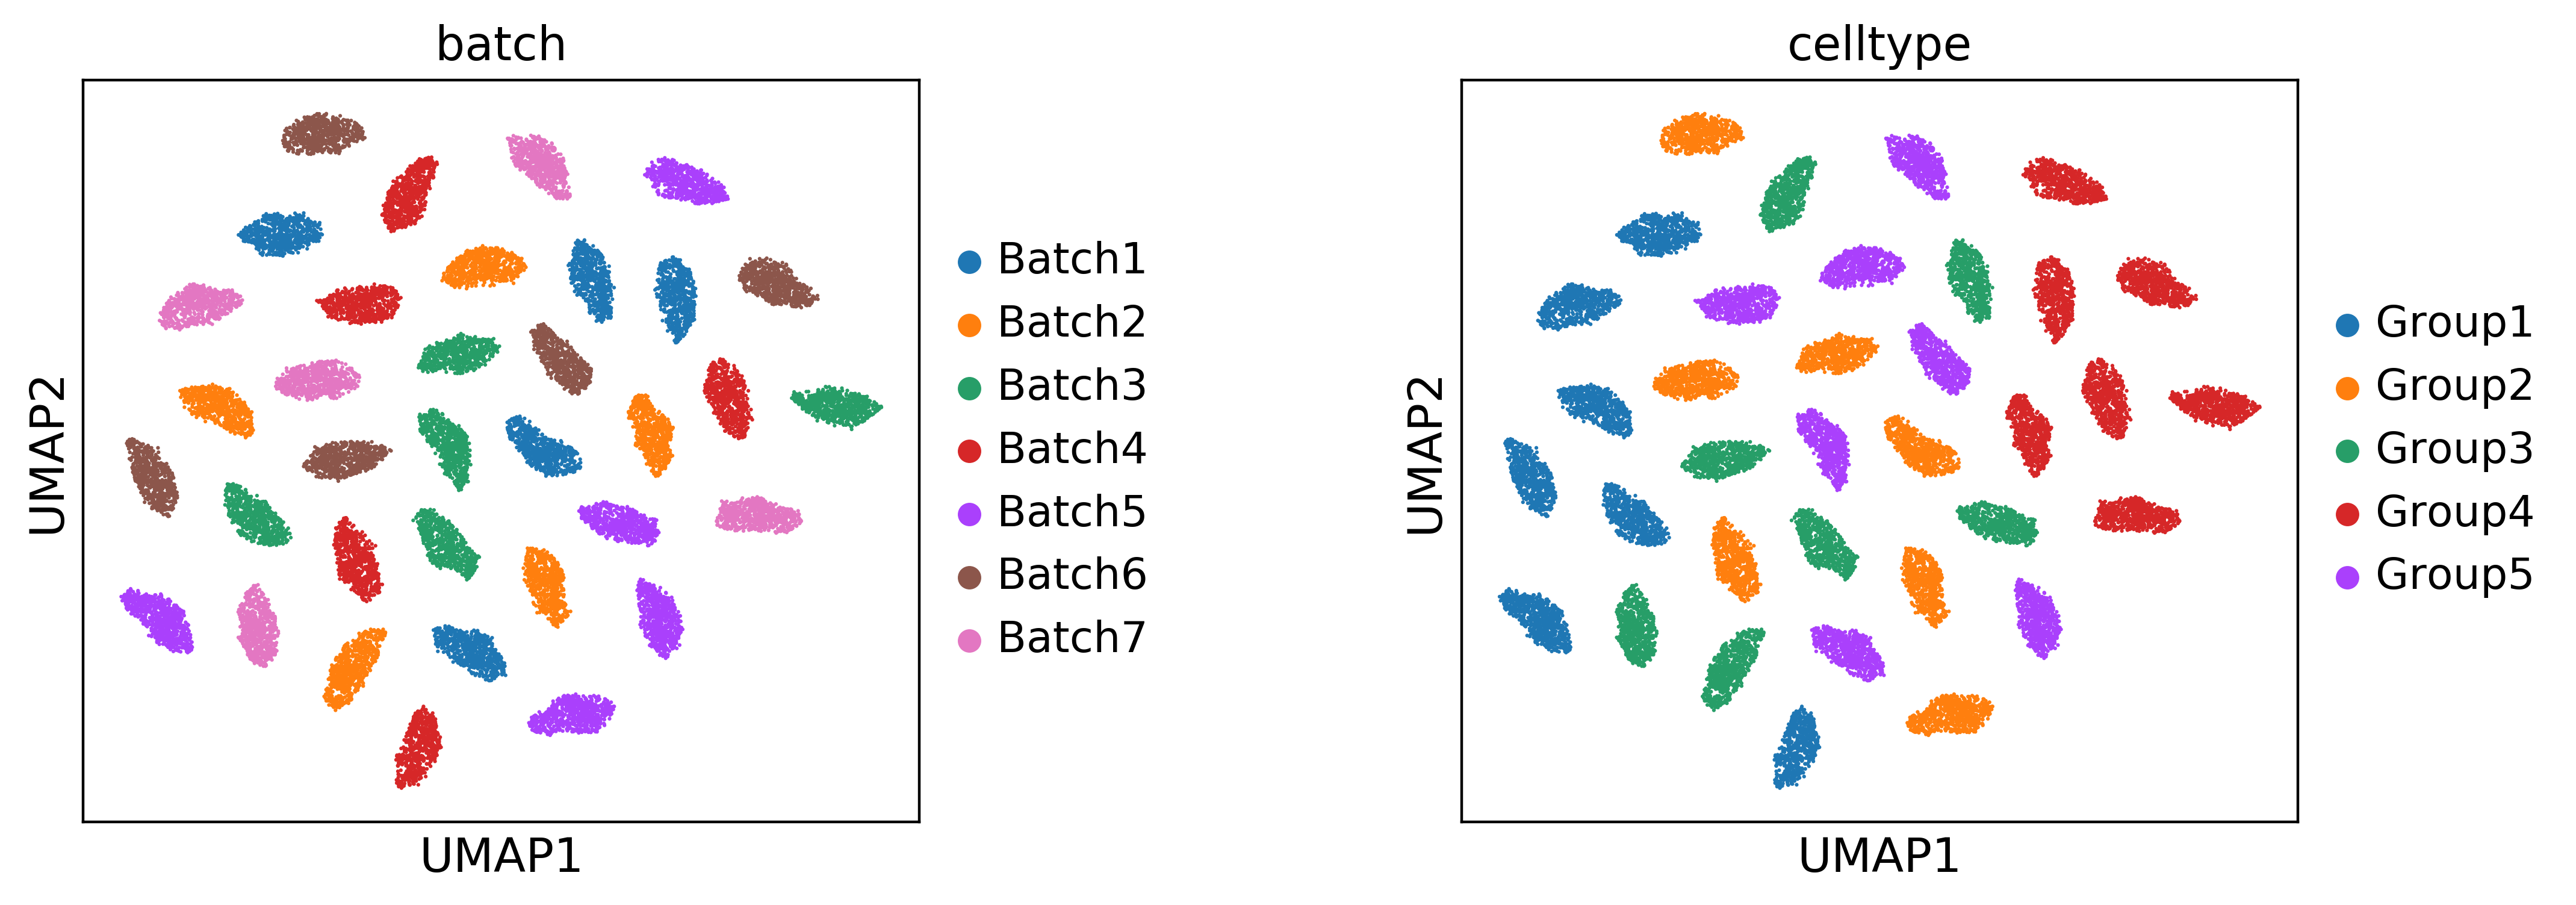

In [21]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

# Perfroming architecture Surgery

In [20]:
new_network = surgeon.operate(network, 
                              new_conditions=target_conditions,
                              init='Xavier', 
                              freeze=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 5000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 9)            0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 5009)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          2564608     concatenate_3[0][0]              
__________

In [21]:
new_network.condition_encoder

{'Batch1': 0,
 'Batch2': 1,
 'Batch3': 2,
 'Batch4': 3,
 'Batch5': 4,
 'Batch6': 5,
 'Batch7': 6,
 'Batch8': 7,
 'Batch9': 8}

## Train with small new dataset containing out-of-sample condition

In [22]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_out_of_sample, 0.85)

In [23]:
train_adata.shape, valid_adata.shape

((6800, 5000), (1200, 5000))

In [24]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  le=new_network.condition_encoder, 
                  n_epochs=100,
                  batch_size=128, 
                  early_stop_limit=25,
                  lr_reducer=20, 
                  n_per_epoch=5,
                  score_filename="./results/convergence/toy/scores_Freezed_scNet.log",
                  save=True, 
                  verbose=2)

Train on 6800 samples, validate on 1200 samples
Epoch 1/100
 - 1s - loss: 773.1426 - kl_recon_loss: 773.1426 - val_loss: 773.9085 - val_kl_recon_loss: 773.9085


IndexError: list index out of range

In [28]:
encoder_labels, _ = surgeon.utils.label_encoder(adata_out_of_sample, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [30]:
adata_out_of_sample.obs[condition_key].value_counts()

Batch9    4000
Batch8    4000
Name: batch, dtype: int64

In [31]:
latent_adata = new_network.to_latent(adata_out_of_sample, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 8000 × 20 
    obs: 'batch', 'celltype', 'n_counts'

In [32]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

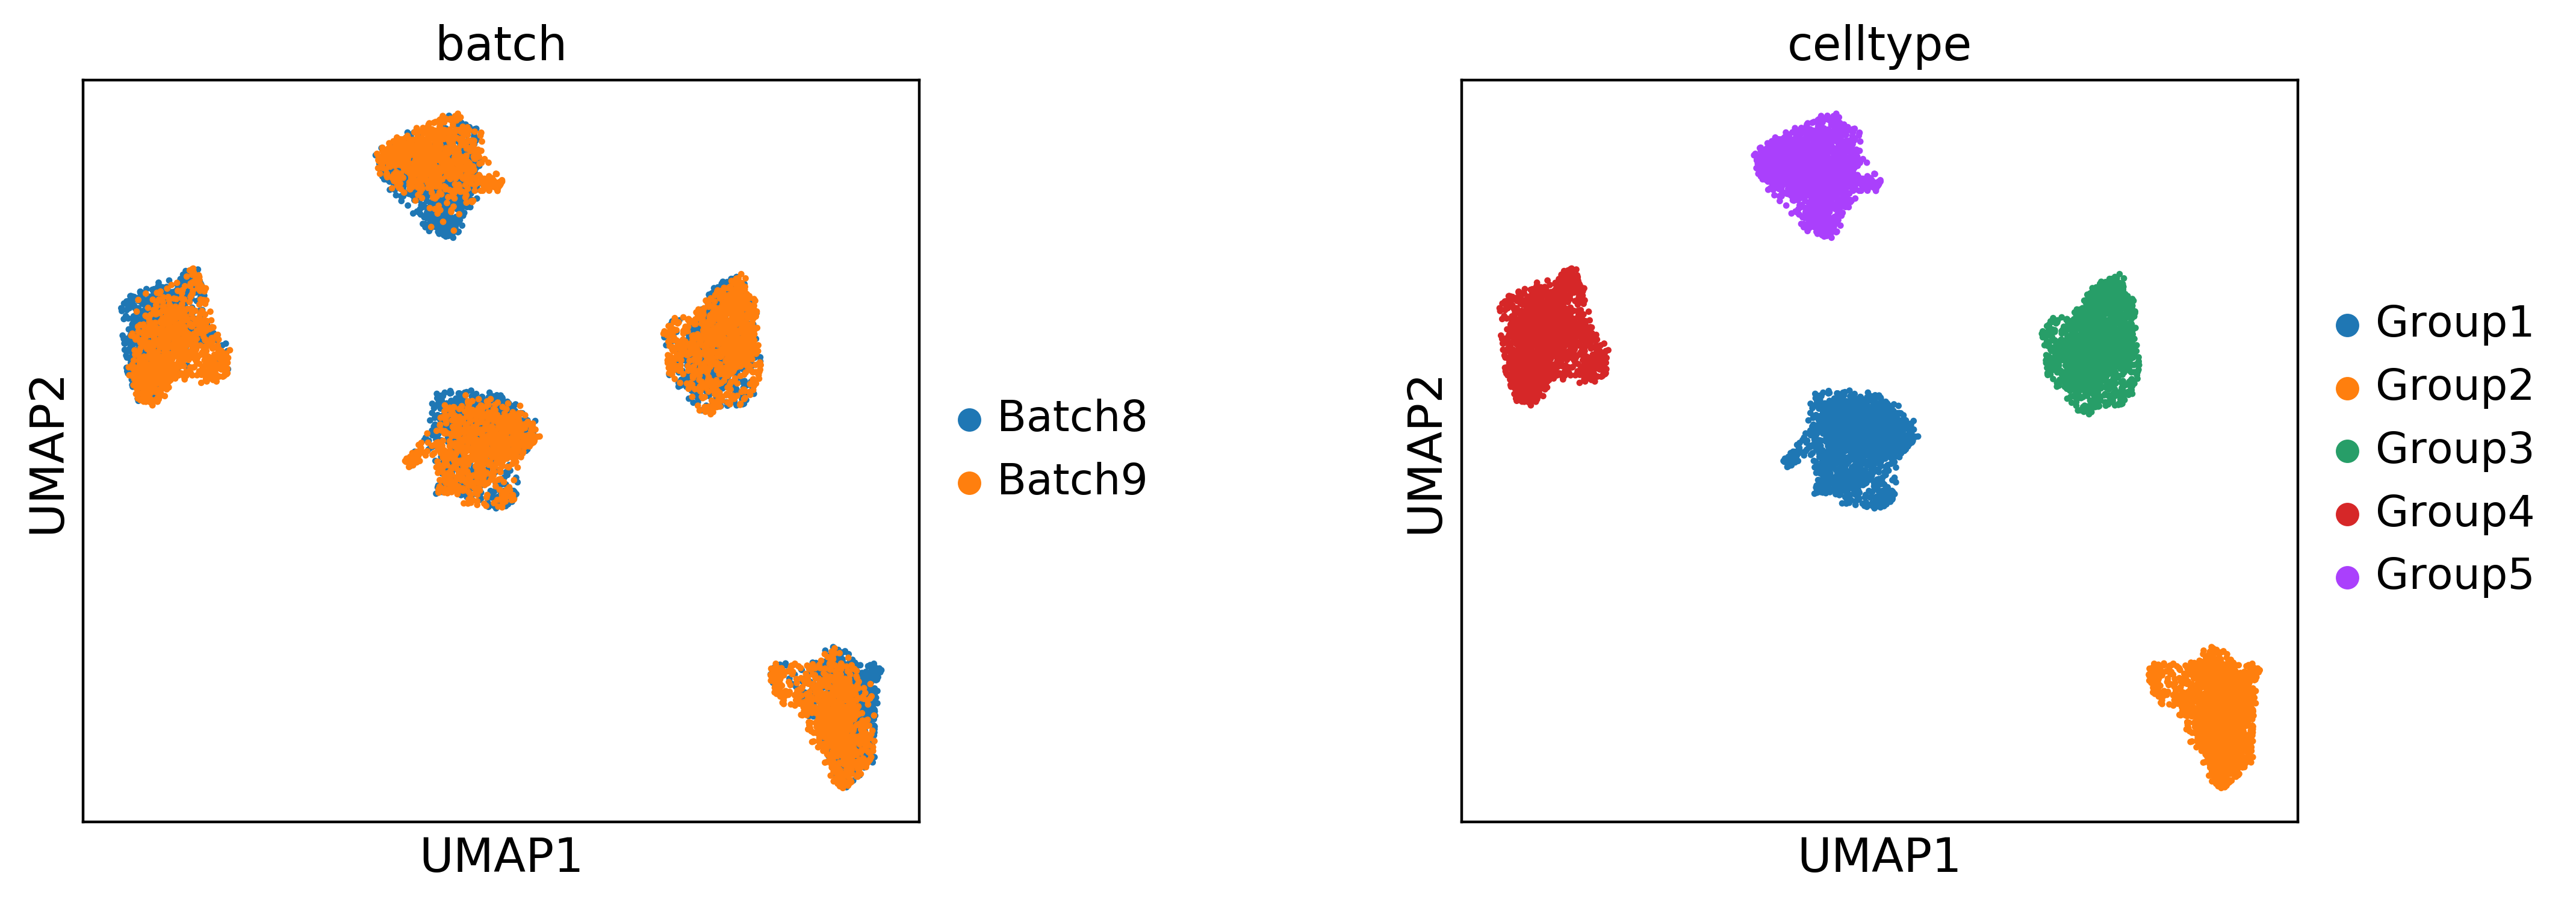

In [33]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

In [35]:
surgeon.metrics.entropy_batch_mixing(latent_adata, label_key=condition_key, n_pools=1)

0.622865080084875

In [36]:
surgeon.metrics.asw(latent_adata, condition_key)

0.013493524

In [37]:
surgeon.metrics.ari(latent_adata, condition_key)

-6.87354074125835e-05

In [38]:
surgeon.metrics.nmi(latent_adata, condition_key)

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


1.598428284047884e-05